# Training file for RDN

## Imports

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision.transforms as transforms
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt
import skimage.metrics as metrics
import platform  # Import the platform module to detect the OS

device = None
if platform.system() == 'Windows':  # Check if the OS is Windows
    import torch_directml  # Import torch_directml only on Windows
    device = torch_directml.device()


if not device:
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.cuda.empty_cache()
    else:
        device = torch.device('cpu')

from rdn import RDN

print(device)

cuda


# Utility function

In [27]:
class SuperResolutionStatsManager(nt.StatsManager):
    
    def __init__(self):
        super(SuperResolutionStatsManager, self).__init__()

    def init(self):
        super(SuperResolutionStatsManager, self).init()
        # Initializing `self.running_psnr`
        self.running_psnr = 0
        self.running_ssim = 0

    def accumulate(self, loss, x, y, d):
        super(SuperResolutionStatsManager, self).accumulate(loss, x, y, d)
        # Updating `self.running_psnr`
        d_numpy = d.detach().to('cpu').numpy()
        y_numpy = y.detach().to('cpu').numpy()

        print(d_numpy.shape, y_numpy.shape)

        range = max(d_numpy.max(), y_numpy.max()) - min(d_numpy.min(), y_numpy.min())
        self.running_psnr += metrics.peak_signal_noise_ratio(d_numpy, y_numpy)
        #self.running_ssim += metrics.structural_similarity(d_numpy, y_numpy, data_range=range)
    
    def summarize(self):
        loss = super(SuperResolutionStatsManager, self).summarize()
        psnr = self.running_psnr / (self.number_update+1e-9 )
        return {'loss': loss, 'psnr': psnr}

def criterion(y, d):
    return F.mse_loss(y, d)

#show image
def myimshow(image, ax=plt):
    image = image.detach().to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    # ax.axis('off')
    return h

## Data loader

In [28]:
new_img_size = 256
common_transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

train_transform = transforms.Compose([
    common_transform,
    #transforms.RandomRotation(degrees=10),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    #transforms.RandomResizedCrop(size=(new_img_size, new_img_size), scale=(0.8, 1.0), ratio=(0.75, 1.333)),
])

valid_transform = transforms.Compose([
    common_transform,
    #transforms.CenterCrop((new_img_size, new_img_size)),
])

In [29]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
#import your datasetclass
from lowhighresimagedataset import LowAndHighResImageDataset

X_train = LowAndHighResImageDataset(transform=train_transform, train=True, onDevice=device)
X_valid = LowAndHighResImageDataset(transform=valid_transform, train=False, onDevice=device)
X_train.get_info()

#train_loader = DataLoader(X_train, batch_size=32, shuffle=True)
#valid_loader = DataLoader(X_valid, batch_size=32, shuffle=True)

Number of train low resolution images: 800
Number of train high resolution images: 800
Number of valid low resolution images: 200
Number of valid high resolution images: 200


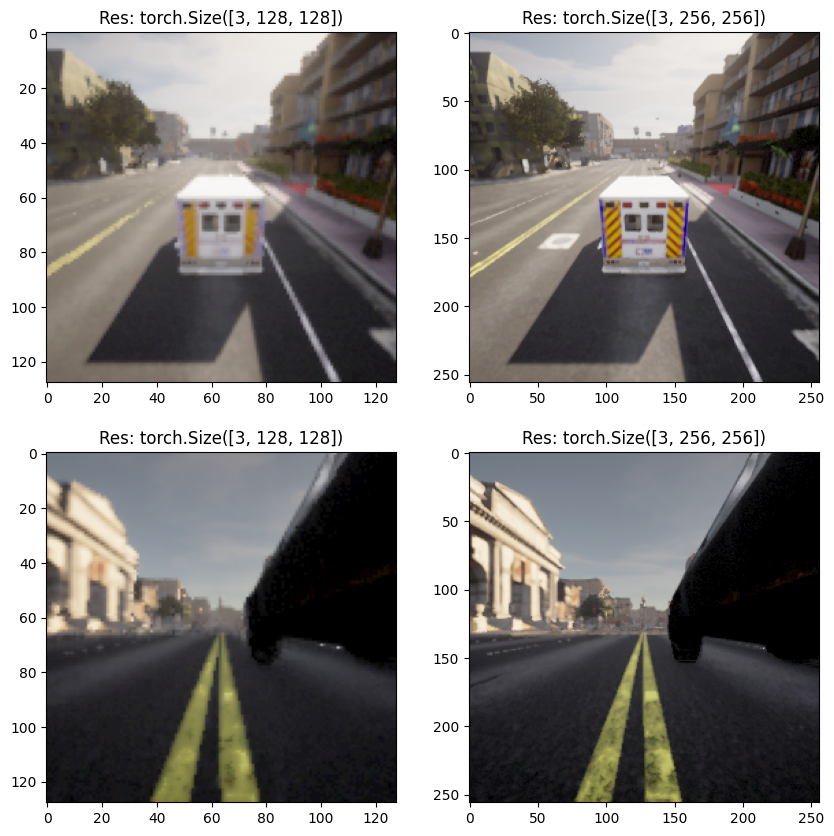

In [30]:
#printing some 2 pairs of low res/high res images
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
ex_low_res1, ex_high_res1 = X_train[np.random.randint(len(X_train))]
ex_low_res2, ex_high_res2 = X_train[np.random.randint(len(X_train))]
ex = [ex_low_res1, ex_high_res1, ex_low_res2, ex_high_res2]
for i, ax in enumerate(axes.flat):
    ax.set_title(f'Res: {ex[i].shape}')
    myimshow(ex[i], ax=ax)

## Experiment on a small batch

In [31]:
batch_size = 10
X_train_batch = [X_train[np.random.randint(len(X_train))] for _ in range(batch_size)]
lr = 1e-3
r = RDN(C=3 , D=10, G=16, G0=16, scaling_factor=2, kernel_size=3, c_dims=X_train[0][0].shape[0], upscaling='shuffle', weights=None)
r = r.to(device)
adam = torch.optim.Adam(r.parameters(), lr=lr)
stats_manager = SuperResolutionStatsManager()
exp = nt.Experiment(r, X_train_batch, None, adam, stats_manager, device, criterion, batch_size=batch_size,
                     output_dir="../results/smallbatchexperiement4", perform_validation_during_training=False)

In [32]:
exp.run(num_epochs=56, plot=None)

Start/Continue training from epoch 53
(10, 3, 256, 256) (10, 3, 256, 256)


ValueError: win_size exceeds image extent. Either ensure that your images are at least 7x7; or pass win_size explicitly in the function call, with an odd value less than or equal to the smaller side of your images. If your images are multichannel (with color channels), set channel_axis to the axis number corresponding to the channels.

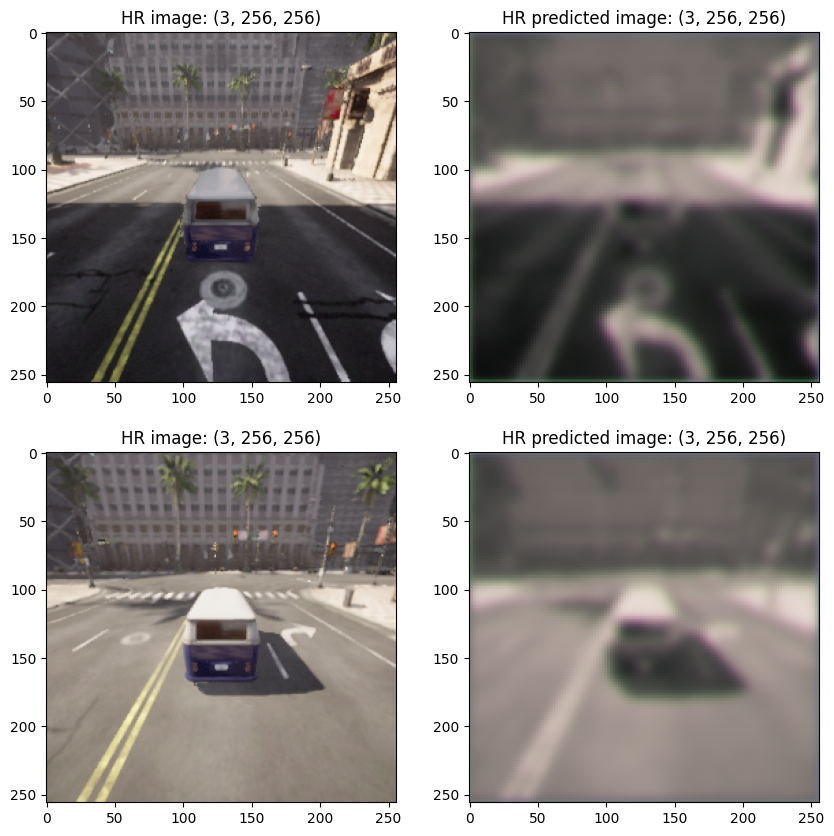

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
train_low_res1, train_high_res1 = X_train_batch[np.random.randint(len(X_train_batch))]
train_low_res2, train_high_res2 = X_train_batch[np.random.randint(len(X_train_batch))]
pred_high_res1 = exp.net(train_low_res1)[0]
pred_high_res2 = exp.net(train_low_res2)[0]
ex = [train_high_res1, pred_high_res1, train_high_res2, pred_high_res2]
for i, ax in enumerate(axes.flat):
    if i%2 == 0:
        ax.set_title(f'HR image: {ex[i].detach().cpu().numpy().shape}')
    else:
         ax.set_title(f'HR predicted image: {ex[i].detach().cpu().numpy().shape}')
    myimshow(ex[i], ax=ax)

# Training the data

In [35]:
train_size = int(0.8 * len(X_train))
valid_size = len(X_train) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(X_train, [train_size, valid_size])
lr = 1e-3
batch_size = 10
r = RDN(C=3 , D=10, G=16, G0=16, scaling_factor=2, kernel_size=3, c_dims=X_train[0][0].shape[0], upscaling='shuffle', weights=None)
r = r.to(device)
adam = torch.optim.Adam(r.parameters(), lr=lr)
stats_manager = SuperResolutionStatsManager()
exp1 = nt.Experiment(r, train_dataset, valid_dataset, adam, stats_manager, device, criterion, batch_size=batch_size,
                     output_dir="../results/superresol1000", perform_validation_during_training=True)

Start/Continue training from epoch 10
Finish training for 10 epochs


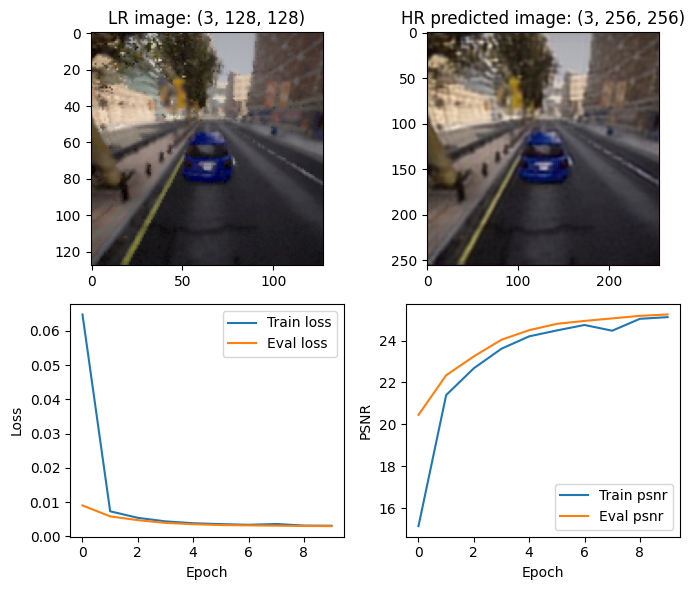

In [36]:
def plot(exp, fig, axes, low_res): ##Only to use when perform_validation_during_training == True
    with torch.no_grad():
        high_res = exp.net(low_res)[0]
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    myimshow(low_res, ax=axes[0][0])
    axes[0][0].set_title(f'LR image: {low_res.detach().cpu().numpy().shape}')
    myimshow(high_res, ax=axes[0][1])
    axes[0][1].set_title(f'HR predicted image: {high_res.detach().cpu().numpy().shape}')    
    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label="Train loss")
    axes[1][1].plot([exp.history[k][0]['psnr'] for k in range(exp.epoch)], label="Train psnr")
    axes[1][0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)], label="Eval loss")
    axes[1][1].plot([exp.history[k][1]['psnr'] for k in range(exp.epoch)], label="Eval psnr")
    axes[1][0].legend()
    axes[1][0].set_xlabel("Epoch")
    axes[1][0].set_ylabel("Loss")        
    axes[1][1].legend()
    axes[1][1].set_xlabel("Epoch")
    axes[1][1].set_ylabel("PSNR")    
    plt.tight_layout()
   
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7,6))
exp1.run(num_epochs=10, plot=lambda exp: plot(exp, fig=fig, axes=axes, low_res=X_valid[np.random.randint(len(X_valid))][0]))
#exp1.run(num_epochs=3, plot=None)

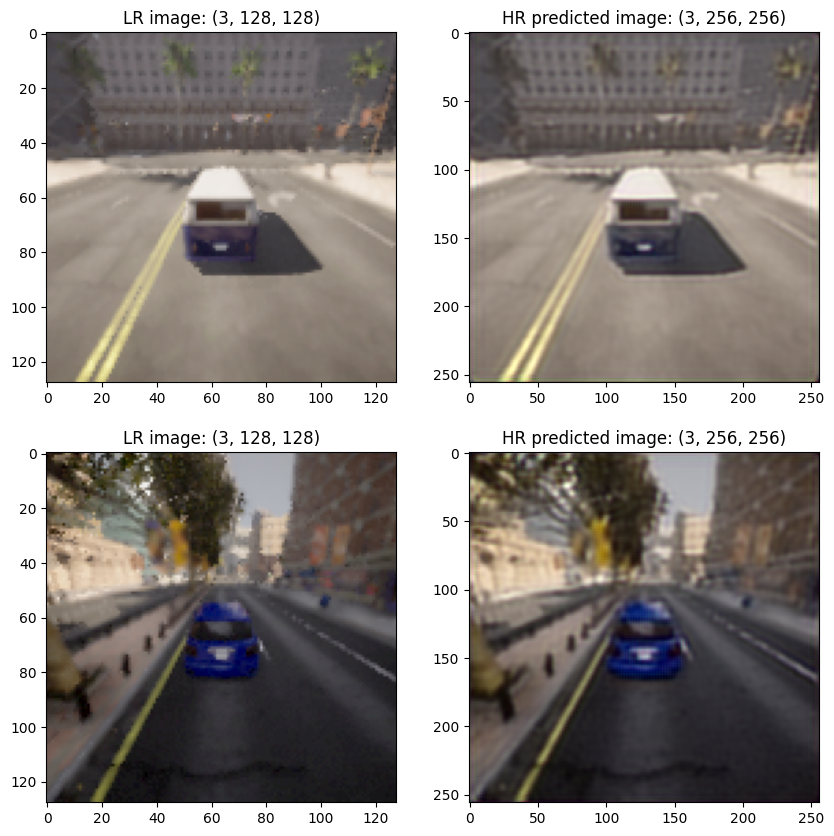

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
test_low_res1, _ = X_valid[np.random.randint(len(X_valid))]
test_low_res2, _ = X_valid[np.random.randint(len(X_valid))]
pred_high_res1 = exp1.net(test_low_res1)[0]
pred_high_res2 = exp1.net(test_low_res2)[0]
ex = [test_low_res1, pred_high_res1, test_low_res2, pred_high_res2]
for i, ax in enumerate(axes.flat):
    if i%2 == 0:
        ax.set_title(f'LR image: {ex[i].detach().cpu().numpy().shape}')
    else:
         ax.set_title(f'HR predicted image: {ex[i].detach().cpu().numpy().shape}')
    myimshow(ex[i], ax=ax)

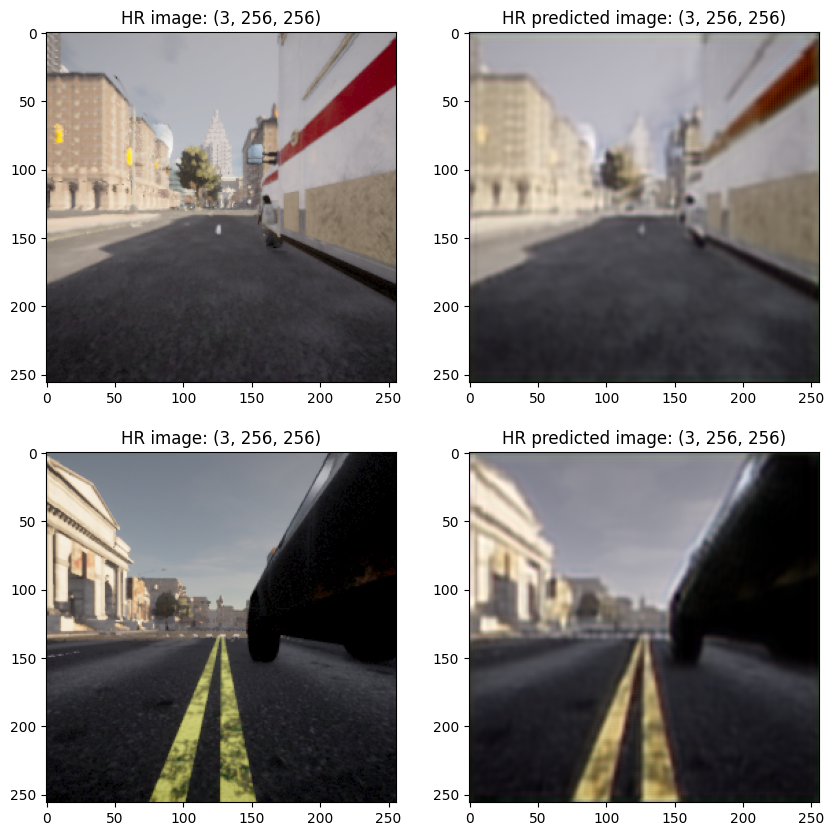

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
test_low_res1, test_high_res1 = X_valid[np.random.randint(len(X_valid))]
test_low_res2, test_high_res2 = X_valid[np.random.randint(len(X_valid))]
pred_high_res1 = exp.net(test_low_res1)[0]
pred_high_res2 = exp.net(test_low_res2)[0]
ex = [test_high_res1, pred_high_res1, test_high_res2, pred_high_res2]
for i, ax in enumerate(axes.flat):
    if i%2 == 0:
        ax.set_title(f'HR image: {ex[i].detach().cpu().numpy().shape}')
    else:
         ax.set_title(f'HR predicted image: {ex[i].detach().cpu().numpy().shape}')
    myimshow(ex[i], ax=ax)